# Kaggle GAN Competition: Monet Painting Dataset

## Challenge Problem:
In this task, we aim to generate realistic data samples from a complex and high-dimensional true data distribution, 
, which is often inaccessible. To achieve this, we will employ a Generative Adversarial Network (GAN), consisting of two neural networks: a Generator G and a Discriminator D. The Generator creates synthetic data samples by transforming random noise into data resembling the true distribution, while the Discriminator distinguishes between real and fake samples. These networks are trained simultaneously in a game-theoretic manner, where the Generator aims to fool the Discriminator, and the Discriminator works to correctly identify real versus fake data. This adversarial process improves the performance of both networks, gradually allowing the Generator to produce more realistic data.

In [4]:
import warnings
import os
import time
from glob import glob
import datetime
import seaborn as sns
import numpy as np, pandas as pd, os
import keras
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 

import zipfile
from keras.layers import Input, Dense, Reshape, Flatten, Dropout,Concatenate
from tensorflow.keras.backend import random_normal, ones_like, zeros_like, mean
from keras.layers import Conv2D, UpSampling2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import concatenate
from keras.initializers import TruncatedNormal
from keras.callbacks import LearningRateScheduler, EarlyStopping, History
from PIL import Image
import warnings
import xml.etree.ElementTree as ET 
import os
print(os.listdir("/kaggle/input/generative-dog-images"))


['Annotation.zip', 'all-dogs.zip']


In [5]:
with zipfile.ZipFile("../input/generative-dog-images/all-dogs.zip","r") as z:
    z.extractall("/kaggle/working/")

dog_dir = "/kaggle/working/all-dogs/"
filenames = os.listdir(dog_dir)

print('Total images:', len(filenames))

with zipfile.ZipFile("../input/generative-dog-images/Annotation.zip","r") as z:
    z.extractall("/kaggle/working/")

dog_dir_Annotation = "/kaggle/working/Annotation/"
filenames_Annotation = os.listdir(dog_dir_Annotation)

print('Total images:', len(filenames_Annotation))

Total images: 20579
Total images: 120


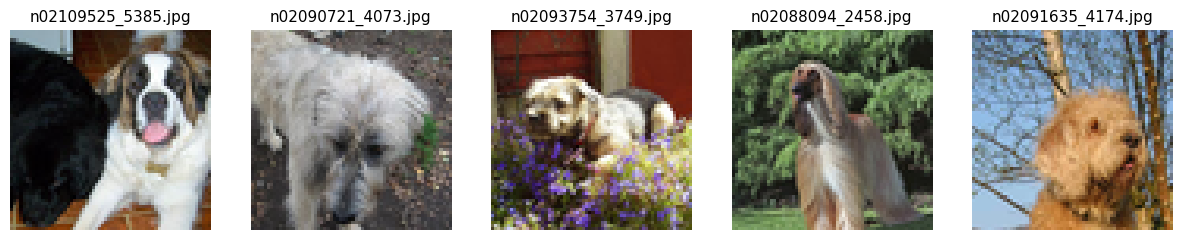

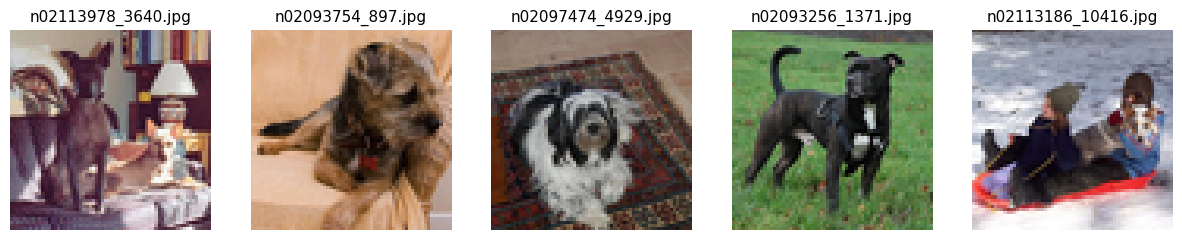

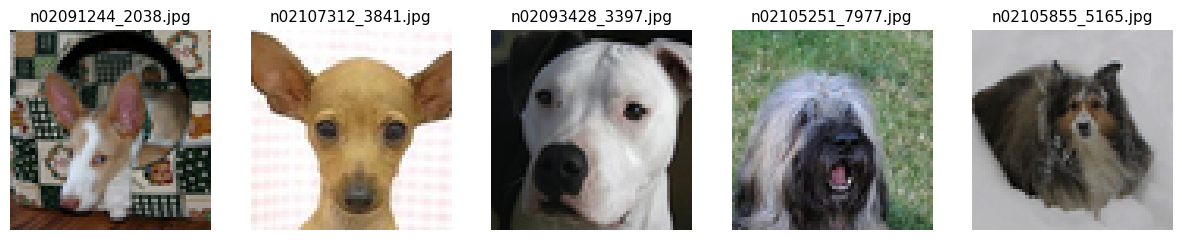

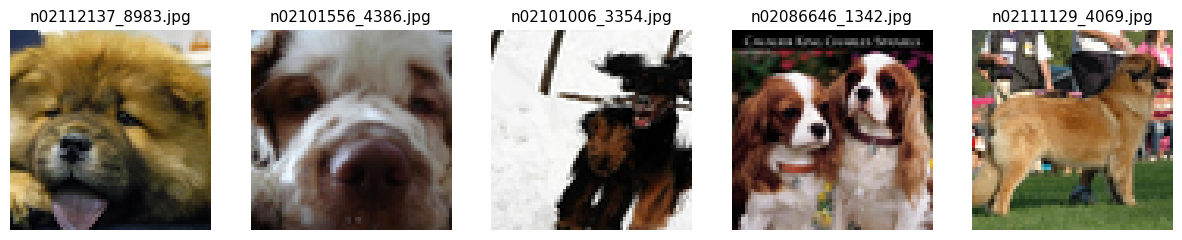

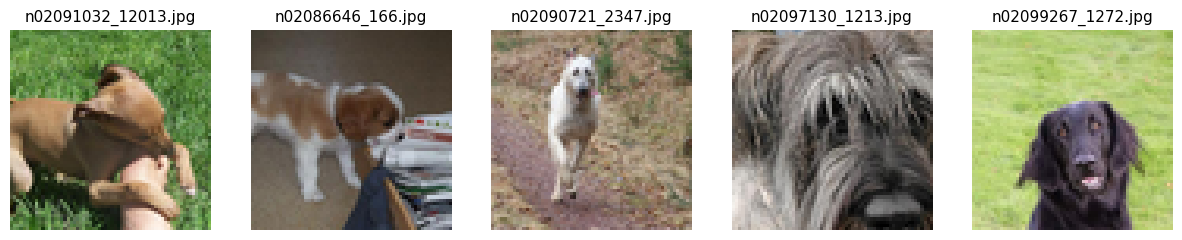

In [6]:
ComputeLB = False
DogsOnly = False


ROOT = '/kaggle/working/'
if not ComputeLB: ROOT = '/kaggle/working/'
IMAGES = os.listdir(ROOT + 'all-dogs/')
breeds = os.listdir(ROOT + 'Annotation/')

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))


# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
# https://www.kaggle.com/paulorzp/show-annotations-and-breeds
if DogsOnly:
    for breed in breeds:
        for dog in os.listdir(ROOT+'Annotation/'+breed):
            try: img = Image.open(ROOT+'all-dogs/'+dog+'.jpg') 
            except: continue           
            tree = ET.parse(ROOT+'Annotation/'+breed+'/'+dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                img2 = img2.resize((64,64), Image.ANTIALIAS)
                imagesIn[idxIn,:,:,:] = np.asarray(img2)
                #if idxIn%1000==0: print(idxIn)
                namesIn.append(breed)
                idxIn += 1
    idx = np.arange(idxIn)
    np.random.shuffle(idx)
    imagesIn = imagesIn[idx,:,:,:]
    namesIn = np.array(namesIn)[idx]
    
# RANDOMLY CROP FULL IMAGES
else:
    IMAGES = np.sort(IMAGES)
    np.random.seed(810)
    x = np.random.choice(np.arange(20579),10000)
    np.random.seed(None)
    for k in range(len(x)):
        img = Image.open(ROOT + 'all-dogs/' + IMAGES[x[k]])
        w = img.size[0]; h = img.size[1];
        if (k%2==0)|(k%3==0):
            w2 = 100; h2 = int(h/(w/100))
            a = 18; b = 0          
        else:
            a=0; b=0
            if w<h:
                w2 = 64; h2 = int((64/w)*h)
                b = (h2-64)//2
            else:
                h2 = 64; w2 = int((64/h)*w)
                a = (w2-64)//2
        img = img.resize((w2,h2), Image.Resampling.LANCZOS)
        img = img.crop((0+a, 0+b, 64+a, 64+b))    
        imagesIn[idxIn,:,:,:] = np.asarray(img)
        namesIn.append(IMAGES[x[k]])
        #if idxIn%1000==0: print(idxIn)
        idxIn += 1
    
# DISPLAY CROPPED IMAGES
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        if not DogsOnly: plt.title(namesIn[x[k*5+j]],fontsize=11)
        else: plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

In [8]:
IMG_SIZE = Input((12288,))
IMG_SIZE_2 = Input((10000,))
NOISE_SIZE = 10000
#BATCH_SIZE = 256 # orig gives ~7.24
#BATCH_SIZE = 512 # gives ~7.25
BATCH_SIZE = 128 # gives 7.22594
#BATCH_SIZE = 128 # gives ~7.222
#BATCH_SIZE = 64

# Build Discriminator

In [9]:
def discriminatorFunction():
    
    input_layer = Dense(12288, activation='sigmoid')(IMG_SIZE_2) 
    input_layer = Reshape((2,12288,1))(concatenate([IMG_SIZE,input_layer]))
    discriminator = Conv2D(filters = 1, kernel_size=[2,1],use_bias=False, name = 'layer_1')(input_layer)
    out = Flatten()(discriminator)
    return out

In [10]:
print("Discriminator")
model = discriminatorFunction()
model_discriminator = Model([IMG_SIZE,IMG_SIZE_2], model)
model_discriminator.get_layer('layer_1').trainable = False
model_discriminator.get_layer('layer_1').set_weights([np.array([[[[-1.0 ]]],[[[1.0]]]])])
model_discriminator.summary()
model_discriminator.compile(optimizer='adam', loss='binary_crossentropy')

Discriminator


I0000 00:00:1745788134.278856      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745788134.279680      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 10000)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 12288)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 12288)          │    122,892,288 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 24576)          │              0 │ input_layer_2[0][0],   │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 2, 12288, 1)    │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_1 (Conv2D)          │ (None, 1, 12288, 1)    │              2 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 12288)          │              0 │ layer_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 122,892,290 (468.80 MB)

 Trainable params: 122,892,288 (468.80 MB)

 Non-trainable params: 2 (8.00 B)

# Build Generator


In [14]:
def GeneratorFunction(noise_shape=(NOISE_SIZE,)):
    input_layer = Input(noise_shape)
    generated = Dense(12288, activation='linear')(input_layer)
        
# COMPILE
    model = Model(inputs=input_layer,outputs = [generated,Reshape((10000,))(input_layer)])
    model.summary()
  
    return model

print("Generator")
model_generator = GeneratorFunction(noise_shape=(NOISE_SIZE,))

Generator


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 10000)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 12288)          │    122,892,288 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 10000)          │              0 │ input_layer_6[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 122,892,288 (468.80 MB)

 Trainable params: 122,892,288 (468.80 MB)

 Non-trainable params: 0 (0.00 B)

# Training the Discriminator


In [11]:
# TRAINING DATA
train_y = (imagesIn[:10000,:,:,:]/255.).reshape((-1,12288))
train_X = np.zeros((10000,10000))
for i in range(10000): train_X[i,i] = 1
zeros = np.zeros((10000,12288))

# ---------------------
#  Train Discriminator
# ---------------------

lr = 0.5
for k in range(5):
    LR_Scheduler = LearningRateScheduler(lambda x: lr)
    h = model_discriminator.fit([zeros,train_X], train_y, epochs = 100,batch_size = BATCH_SIZE, callbacks=[LR_Scheduler], verbose=0)
    print('Epoch',(k+1)*10,'/50 - loss =',h.history['loss'][-1] )
    if h.history['loss'][-1]<0.533: lr = 0.1

I0000 00:00:1745788173.749432      98 service.cc:148] XLA service 0x7f85d80090b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745788173.751311      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745788173.751346      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745788174.044371      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745788176.815428      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 10 /50 - loss = 0.5325140357017517
Epoch 20 /50 - loss = 0.5324963927268982
Epoch 30 /50 - loss = 0.5324907302856445
Epoch 40 /50 - loss = 0.5324869155883789
Epoch 50 /50 - loss = 0.5324838757514954


In [36]:
del train_X, train_y, imagesIn

# Building GAN

We will purposely give our Generator a bottleneck in its memory. Using poor memory forces the Generator to learn a generalization of images and not memorize the images exactly.

In [37]:
# BUILD GENERATOR NETWORK
BadMemory = True

if BadMemory:
    seed = Input((10000,))
    x = Dense(2048, activation='elu')(seed)
    x = Reshape((8,8,32))(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), activation='linear', padding='same')(x)
    generated = Flatten()(x)
else:
    seed = Input((10000,))
    generated = Dense(12288, activation='linear')(seed)

# COMPILE
generator = Model(seed, [generated,Reshape((10000,))(seed)])

# DISPLAY ARCHITECTURE
generator.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27            │ (None, 10000)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2048)           │     20,482,048 │ input_layer_27[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 8, 8, 32)       │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 8, 8, 128)      │         36,992 │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 16, 16, 128)    │              0 │ conv2d[0][0]           │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 64)     │         73,792 │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 32, 32, 64)     │              0 │ conv2d_1[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 32)     │         18,464 │ up_sampling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_2           │ (None, 64, 64, 32)     │              0 │ conv2d_2[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 3)      │            867 │ up_sampling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 12288)          │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 10000)          │              0 │ input_layer_27[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 20,612,163 (78.63 MB)

 Trainable params: 20,612,163 (78.63 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# BUILD GENERATIVE ADVERSARIAL NETWORK
model_discriminator.trainable = False

gan_input = Input(shape=(10000,))
x = generator(gan_input)
gan_output = model_discriminator(x)

gan = Model(gan_input, gan_output)

# Correct setting of conv2d weights
conv_layer = gan.get_layer('functional_11').get_layer('conv2d_1')
weights = conv_layer.get_weights()

# Set weights properly
new_kernel = np.zeros_like(weights[0])
new_bias = np.zeros_like(weights[1])
conv_layer.set_weights([new_kernel, new_bias])

# COMPILE GAN
gan.compile(optimizer=Adam(learning_rate=5.0), loss='mean_squared_error')

# DISPLAY ARCHITECTURE
gan.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38            │ (None, 10000)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_11             │ [(None, 12288), (None, │     20,612,163 │ input_layer_38[0][0]   │
│ (Functional)              │ 10000)]                │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 12288)          │    122,892,290 │ functional_11[10][0],  │
│                           │                        │                │ functional_11[10][1]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 143,504,453 (547.43 MB)

 Trainable params: 20,612,163 (78.63 MB)

 Non-trainable params: 122,892,290 (468.80 MB)

# Training GAN

In [62]:
train = np.zeros((10000,10000))
for i in range(10000): train[i,i] = 1
zeros = np.zeros((10000,12288))*500

Steps_per_epoch = 50
print("Training begins... Total steps per epoch: {}".format(Steps_per_epoch ))

Training begins... Total steps per epoch: 50


Epoch 1 /9 - loss = 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


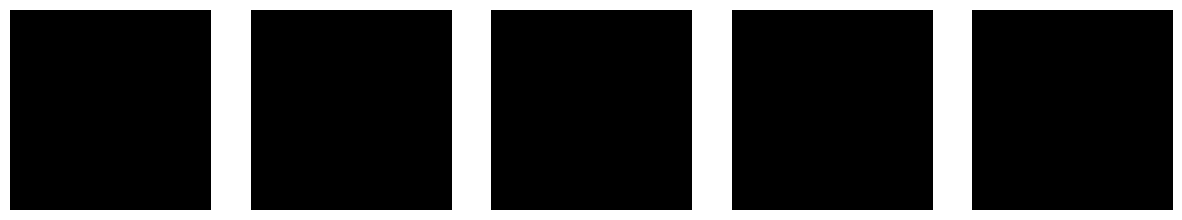

Epoch 2 /9 - loss = 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


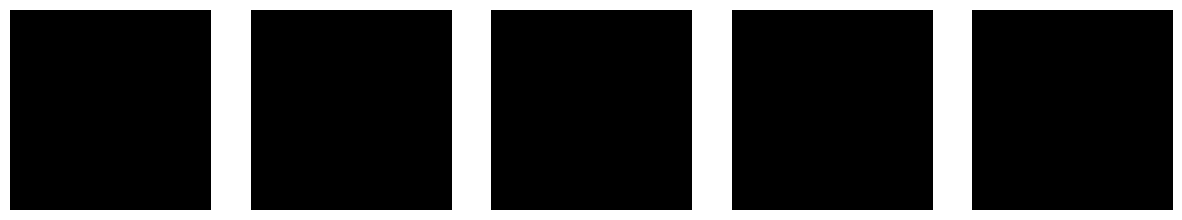

Epoch 3 /9 - loss = 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


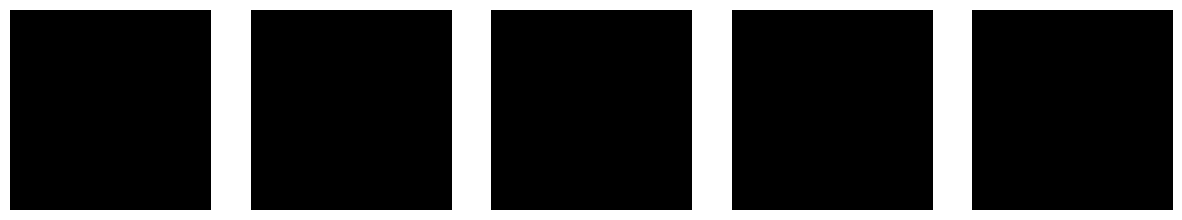

KeyboardInterrupt: 

In [69]:
# TRAIN NETWORKS
ep = 1; it = 9
if BadMemory: lr = 0.005
else: lr = 5.
    
for k in range(it):  

    # BEGIN DISCRIMINATOR COACHES GENERATOR
    annealer = LearningRateScheduler(lambda x: lr)
    h = gan.fit(train, zeros, epochs = 10, batch_size=128, callbacks=[annealer], verbose=0)

    # DISPLAY GENERATOR LEARNING PROGRESS 
    print('Epoch',(k+1),'/'+str(it)+' - loss =',h.history['loss'][-1] )
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((10000))
        xx[np.random.randint(10000)] = 1
        plt.subplot(1,5,j+1)
        img = generator.predict(xx.reshape((-1, 10000)))[0]
        
        # Ensure the image is reshaped to (64, 64, 3)
        img = img.reshape((64, 64, 3))

        # Replace NaNs or Infs with 0
        img = np.nan_to_num(img, nan=0.0, posinf=255, neginf=0)

        # Clip image values to be within the valid range for uint8 (0-255)
        img = np.clip(img, 0, 255).astype('uint8')
        img_pil = Image.fromarray(img)
        plt.axis('off')
        plt.imshow(img)
    plt.show()  
            
    # ADJUST LEARNING RATES
    if BadMemory:
        ep *= 2
        if ep>=32: lr = 0.001
        if ep>256: ep = 256
    else:
        if h.history['loss'][-1] < 25: lr = 1.
        if h.history['loss'][-1] < 1.5: lr = 0.5